# Import tools

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import graphviz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate as interp
from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None


In [2]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
set_option("display.max_rows", 15)
set_option('display.width', 200)
np.set_printoptions(suppress=True, threshold=5000)

# Exploring the dataset

In [ ]:
TrainDataPath = '../data/lithofacies_data/train/'
filename_AB = 'GY-1_lithofacies_vectors_0.1.csv'   # lithofacies_vectors.csv  GY-1_lithofacies_vectors_0.1.csv  training_data.csv
TrainDataPath = os.path.join(TrainDataPath,filename_AB)
print(TrainDataPath)


TestDataPath = '../data/lithofacies_data/test/'
filename_A = 'YX-58_lithofacies_vectors_0.1.csv'   # lithofacies_vectors.csv  GY-1_lithofacies_vectors_0.1.csv YX-58_lithofacies_vectors_0.02.csv  ALEXANDER D_lithofacies_vectors.csv
TestDataPath = os.path.join(TestDataPath,filename_A)
print(TestDataPath)

In [ ]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone

facies_colors = None
facies_labels = None
input_vectors = None
DEPTH_col_name = None
data_model = 2

if data_model == 1:
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72',
        '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                    'WS', 'D','PS', 'BS']
    input_vectors = ["GR","ILD_log10","DeltaPHI","PHIND","NM_M","RELPOS"]
    DEPTH_col_name = "Depth"
    
if data_model == 2:
    facies_colors = ['#632423', '#0070C0','#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']
    facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相',
                    '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']
    input_vectors = ["GR","CNL","DT","DEN","MSFL","RS","RD"]
    # 深度列名称
    DEPTH_col_name = "DEPTH"




## Read Data

In [ ]:
training_data = pd.read_csv(TrainDataPath,engine='python',encoding='GBK')

blind =  pd.read_csv(TestDataPath,engine='python',encoding='GBK')

In [ ]:
# blind = training_data[training_data['Well Name'] == '34']
# training_data = training_data[training_data['Well Name'] != '58']
# training_data = training_data[training_data['Well Name'] != '34']

In [ ]:
# training_data['Well Name'] = training_data['Well Name'].astype('category')
# training_data['Formation'] = training_data['Formation'].astype('category')
# training_data['Well Name'].unique()

In [ ]:


# 标签所在列
facies_labels_col = "Facies"

# adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])
adjacent_facies = [[0],[1], [0,1], [1,2,3], [4], [5], [5,6]]
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row[facies_labels_col] -1]

# 如果标签是中文，执行下面一段    
# training_data.loc[:,facies_labels_col] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
# training_data.describe()

In [ ]:
# PE_mask = training_data['PE'].notnull().values
# training_data = training_data[PE_mask]

In [ ]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    
    cluster = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 1
    f, ax = plt.subplots(nrows=1, ncols = total_fig_cols, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], logs[DEPTH_col_name])
    final_line = len(input_vectors)
    im = ax[final_line].imshow(cluster, interpolation='none', aspect='auto',
                               cmap=cmap_facies,vmin = 1,vmax = len(facies_colors))
    
    divider = make_axes_locatable(ax[final_line])
    cax = divider.append_axes("right", size="25%", pad=0.05)
    # cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    # cbar.set_label((17*' ').join(facies_labels))
    cbar.set_label((4*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min(),logs[input_vectors[i]].max())
        
    ax[final_line].set_xlabel('Facies')
    
    for i in range(len(ax)-1):
        ax[i].set_yticklabels([]);
        
    ax[final_line].set_yticklabels([])
    ax[final_line].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [ ]:
make_facies_log_plot(
    training_data,
    facies_colors)

In [ ]:
# make_facies_log_plot(
#     training_data[training_data['Well Name'] == '58'],
#     facies_colors)

## Analysis Data

In [ ]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

In [ ]:
facies_color_map,list(reversed(facies_labels))

In [ ]:
#save plot display settings to change back to when done plotting with seaborn
# inline_rc = dict(mpl.rcParams)

import seaborn as sns
# sns.set()
# sns.pairplot(training_data.drop(['Well Name','DEPTH','CAL','SP'],axis=1),hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_labels)))

# #switch back to default matplotlib plot style
# mpl.rcParams.update(inline_rc)

In [ ]:
from sklearn import preprocessing

correct_facies_labels = training_data['Facies'].values

# feature_vectors = training_data.drop(['Formation', 'Well Name', 'DEPTH','Facies','FaciesLabels'], axis=1)
feature_vectors = training_data[input_vectors]
feature_vectors.describe()

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [ ]:
feature_vectors

In [ ]:
from sklearn.model_selection import train_test_split

# 归一化
# X_train, X_test, y_train, y_test = train_test_split(
#         scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

# 不归一化
X_train, X_test, y_train, y_test = train_test_split(
        feature_vectors, correct_facies_labels, test_size=0.2, random_state=42)

In [ ]:
y_train

# Training the Decision Tree classifier

class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)

In [ ]:
from sklearn import tree as tree
# based_method = 'gini' | 'entropy'
based_method = 'entropy'
tree_depth = 10
class_weight = {0:0.22, 1:0.01,2:0.02,3:0.03,4:0.30,5:0.38,6:0.04}
# clf = tree.DecisionTreeClassifier(criterion = based_method,max_depth = tree_depth)
clf = tree.DecisionTreeClassifier(criterion = based_method,max_depth = tree_depth)

In [ ]:
training_img_file_saving_path = 'model_training_images/'
child_dir_name ="decision_tree" + "_"  + "training/"
model_training_img_file_saving_path = os.path.join(training_img_file_saving_path,child_dir_name)
model_training_img_name =   "decision_tree"  + "_" + based_method + "_tree_depth_"+ str(tree_depth)
    
if not os.path.exists(model_training_img_file_saving_path):
    os.makedirs(model_training_img_file_saving_path)
        
model_testing_image_name =  "decision_tree" + "_" + based_method + "_tree_depth_" + str(tree_depth)
child_dir_name =  "decision_tree" + "_"  + "testing/"
testing_img_file_saving_path = 'model_testing_images/'
model_testing_img_file_saving_path = os.path.join(testing_img_file_saving_path,child_dir_name)
if not os.path.exists(model_testing_img_file_saving_path):
    os.makedirs(model_testing_img_file_saving_path)

In [ ]:
model_save_path = os.path.join("model/", 'facies_decision-tree'  + "_train/")
#model_save_path = os.path.join("model/", 'facies_' + model_type.lower() + "_train/",child_dir_name)
if os.path.exists(model_save_path):
    model_path = model_save_path
else:
    os.makedirs(model_save_path)
    model_path = model_save_path
print(model_path)

In [ ]:
model_name = 'facies_tree_' + based_method 
model_file = model_path + model_name + '.pkl'
print("model_name:",model_name)
print("model_file:",model_file)

In [ ]:
clf.fit(X_train,y_train)

## Plot Decision Tree

In [ ]:
out_dot_file = model_path + model_name

In [ ]:
dot_data = tree.export_graphviz(clf, out_file = out_dot_file + '.dot',feature_names=feature_vectors.columns,class_names=facies_labels,
                               filled=True, rounded=True,special_characters=True)

In [ ]:
with open(out_dot_file + '.dot',encoding='utf-8') as fj:
    source = fj.read()

In [ ]:
graph = graphviz.Source(source, format="png") 

In [ ]:
graph

In [ ]:
graph.encoding = 'utf-8'

In [ ]:
graph.render(out_dot_file)
# out_dot_file

## Save Model

In [ ]:
# from sklearn.externals import joblib
import joblib

joblib.dump(clf, model_file)

# Valid Model

In [ ]:
predicted_labels = clf.predict(X_test)

In [ ]:
clf.score(X_test,predicted_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

In [ ]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(conf, xticklabels=facies_labels, yticklabels=facies_labels, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [ ]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [ ]:
# adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [ ]:
adjacent_facies = None
if data_model == 1:
    # adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
    adjacent_facies = [[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]]
if data_model == 2:
    # adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])
    adjacent_facies = [[0],[1], [0,1], [1,2,3], [4], [5], [5,6]]

In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

In [ ]:
def per_class_accuracy(conf):
    per_class_correct = 0.
    nb_classes = conf.shape[0]
    per_acc = []
    for i in np.arange(0,nb_classes):
        acc = 0
        per_class_correct = conf[i][i]
        per_class_sum = 0
        per_class_sum = per_class_sum + sum(conf[i])
        print(per_class_sum)
        acc = per_class_correct/per_class_sum
#         acc = per_class_correct/sum(sum(conf))
        per_acc.append(acc)
    return per_acc

In [ ]:
per_class_accuracy_list = per_class_accuracy(conf)
for i in range(len(per_class_accuracy_list)):
    print(i,' class facies classification accuracy = %f' % per_class_accuracy_list[i])

## Calculate ROC

see: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html?highlight=decision_function  
if hasattr(clf, "decision_function"):  
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])  
        else:  
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

In [ ]:
y_score = clf.predict_proba(X_test) 
y_score

In [ ]:
import tensorflow as tf
y = tf.keras.utils.to_categorical(y_test,num_classes=len(facies_labels))
y

In [ ]:
from sklearn.metrics import roc_curve, auc

#decision_function对于SVC返回每个样本距离决策边界的距离
#decision_function对于LR返回预测样本的置信度分数——该样本与超平面的有符号距离

n_classes = len(facies_labels)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])   
    #y_test样例真实标签，y_score学习器预测的样例的概率 
    roc_auc[i] = auc(fpr[i], tpr[i])   
    #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())   #ravel函数将矩阵展开成向量
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
y.ravel(),y.ravel().shape

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])   
        #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

    # Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
plt.rcParams['figure.figsize']=(8,6)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':')

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),
             color='navy', linestyle=':')

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
# colors = facies_colors
for i, color_use in zip(range(n_classes), facies_colors):
    plt.plot(fpr[i], tpr[i], color = color_use, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(model_training_img_file_saving_path + model_training_img_name  + '_ROC.png', dpi=330,  bbox_inches='tight')
plt.show()

In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

In [ ]:
display_cm(conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

# Applying the classification model to the blind data

In [ ]:
blind

## Load Model

In [ ]:
clf = joblib.load(model_file)

In [ ]:
y_blind = blind['Facies'].values

In [ ]:
well_features = blind.drop(['Well Name','Facies','DEPTH','CAL','SP'], axis=1)

In [ ]:
# X_blind = scaler.transform(well_features)


X_blind = well_features

In [ ]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

In [ ]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

In [ ]:
per_class_accuracy_list_2 = per_class_accuracy(cv_conf)
for i in range(len(per_class_accuracy_list_2)):
    print(i,' class facies classification accuracy = %f' % per_class_accuracy_list_2[i])

In [ ]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

In [ ]:
# 考虑合并岩相
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(conf, xticklabels=facies_labels, yticklabels=facies_labels, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + '_val_confusion_matrix.png', dpi=330,  bbox_inches='tight')
plt.show()

In [ ]:
y_score = clf.predict_proba(X_blind) 
y_score

In [ ]:
import tensorflow as tf
y = tf.keras.utils.to_categorical(y_blind-1,num_classes=len(facies_labels))
y

In [ ]:
# from sklearn.metrics import roc_curve, auc

#decision_function对于SVC返回每个样本距离决策边界的距离
#decision_function对于LR返回预测样本的置信度分数——该样本与超平面的有符号距离

n_classes = len(facies_labels)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])   
    #y_test样例真实标签，y_score学习器预测的样例的概率 
    roc_auc[i] = auc(fpr[i], tpr[i])   
    #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())   #ravel函数将矩阵展开成向量
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
y.ravel(),y.ravel().shape

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])   
        #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

    # Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

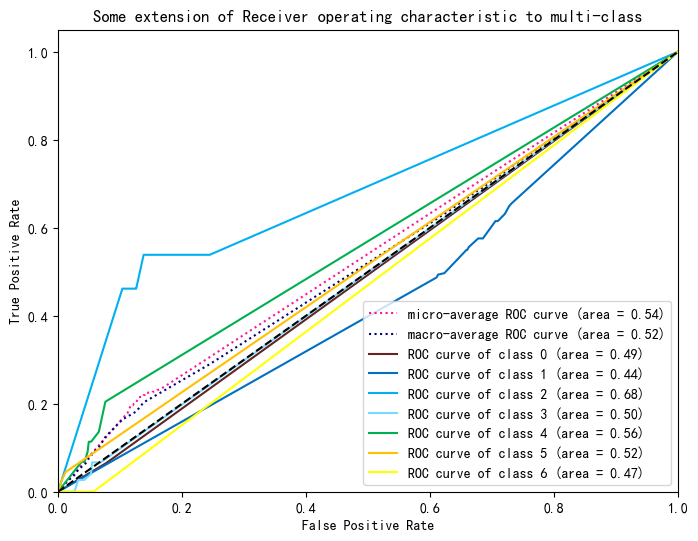

In [76]:
plt.rcParams['figure.figsize']=(8,6)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':')

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),
             color='navy', linestyle=':')

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
# colors = facies_colors
for i, color_use in zip(range(n_classes), facies_colors):
    plt.plot(fpr[i], tpr[i], color = color_use, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(model_training_img_file_saving_path + model_training_img_name  + '_ROC.png', dpi=220,  bbox_inches='tight')
plt.show()

In [77]:
import math
def compare_facies_plot(logs, compadre, facies_colors):
     #make sure logs are sorted by depth
    logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    DEPTH_col = logs[DEPTH_col_name]
    
    cluster1 = np.repeat(np.expand_dims(logs["Prediction"].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 2
    f, ax = plt.subplots(nrows=1, ncols=len(input_vectors) + 2, figsize=(total_fig_cols*2,8))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], DEPTH_col)
    final_line = len(input_vectors)

    im1 = ax[final_line].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
    im2 = ax[final_line+1].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
    
    divider = make_axes_locatable(ax[final_line+1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((25*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min()*0.98,logs[input_vectors[i]].max() * 1.02)
        ax[i].set_ylim(zbot, ztop)
        
    # for i in range(len(ax)-2):
    #     ax[i].invert_yaxis()
    #     # ax[i].set_ylim(ztop,zbot)
    #     ax[i].set_yticklabels([])
    #     ax[i].set_ylim(zbot, ztop)
    # ax[0].set_yticks([])
    
        
  
    ax[final_line].set_xlabel(compadre)
    ax[final_line + 1].set_xlabel('Real Facies')
    ax[final_line].set_yticklabels([])
    ax[final_line].set_xticklabels([])
    ax[final_line + 1].set_yticklabels([])
    ax[final_line + 1].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
  

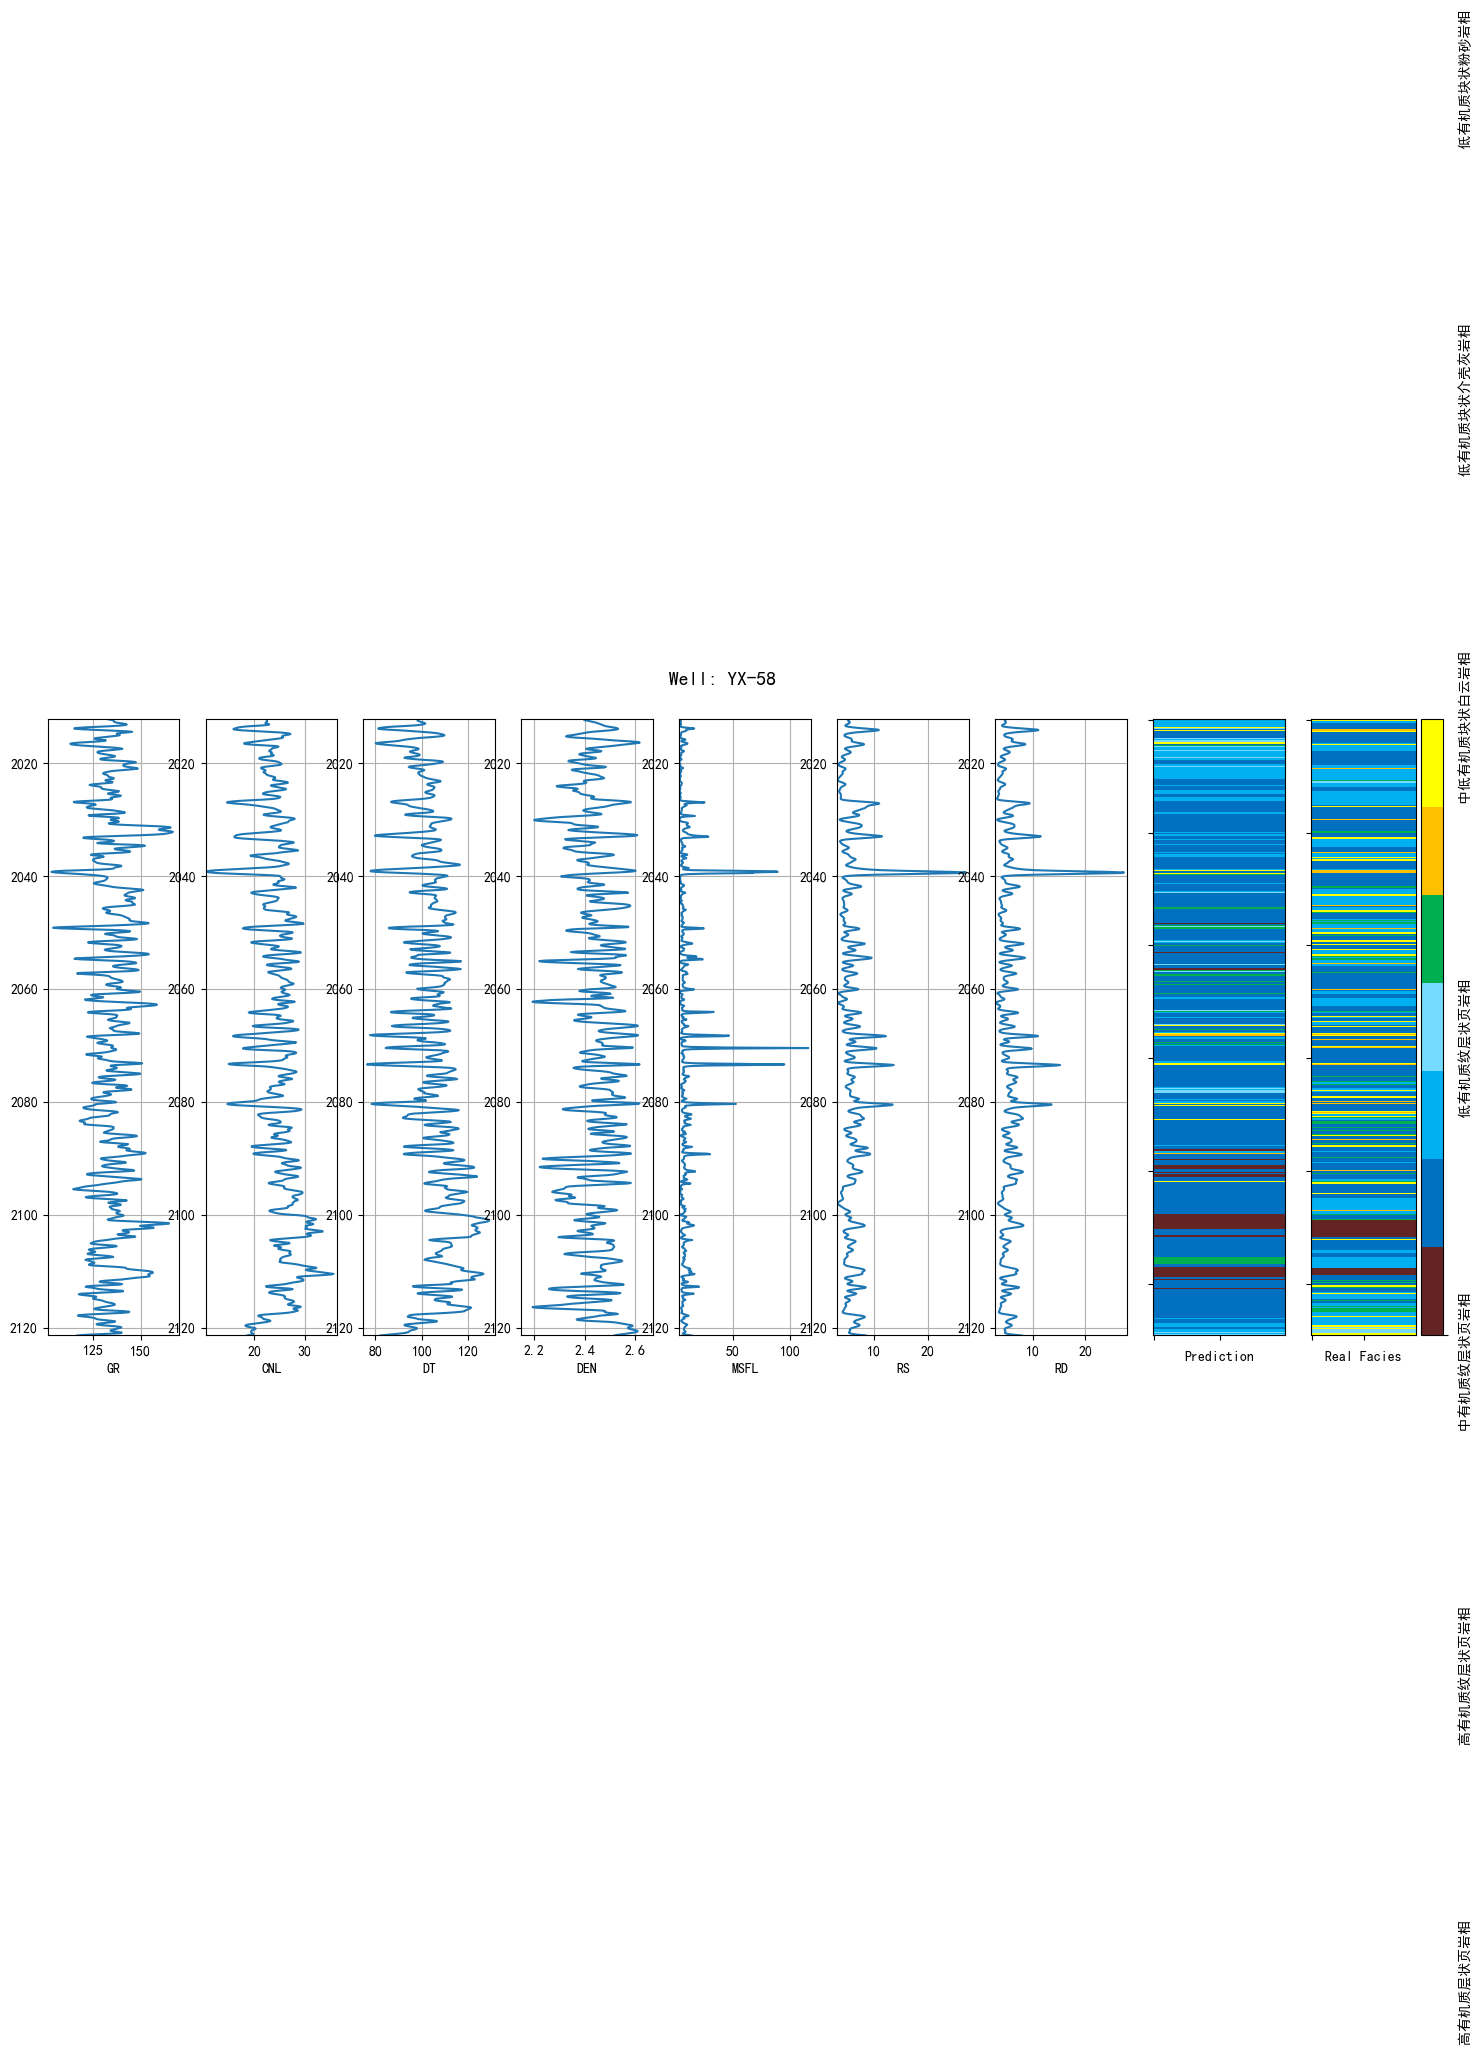

In [78]:
compare_facies_plot(blind, 'Prediction', facies_colors)

# Applying the classification model to new data

In [79]:
blind

,DEPTH,CAL,SP,GR,CNL,DT,DEN,MSFL,RS,RD,Facies,Well Name,Prediction
0,2012.3,9.3512,162.5924,133.0452,22.5484,98.0852,2.3972,4.5072,5.2958,4.8964,6,YX-58,2
1,2012.4,9.3496,162.6872,134.7578,22.5156,98.1316,2.3984,4.6278,5.1578,4.7058,6,YX-58,2
2,2012.5,9.3360,162.8000,135.6130,22.4660,98.1660,2.4080,4.6110,5.1530,4.6730,6,YX-58,2
3,2012.6,9.3232,162.8720,135.7674,22.5372,98.6876,2.4192,4.6086,5.2818,4.7770,2,YX-58,2
4,2012.7,9.3194,162.9254,135.9260,22.5154,99.3286,2.4298,4.5486,5.4064,4.8762,2,YX-58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2121.0,8.6860,167.7170,138.9920,19.5630,91.9960,2.5790,6.6650,5.4110,4.8130,3,YX-58,3
1088,2121.1,8.7100,167.8194,133.5352,19.7814,89.8688,2.5622,6.2690,5.7942,5.1658,6,YX-58,3
1089,2121.2,8.7220,167.7712,126.5028,19.7904,87.2976,2.5448,7.2152,6.4504,5.7964,6,YX-58,2
1090,2121.3,8.7248,167.6516,120.2804,19.4012,84.6108,2.5292,10.1568,7.3772,6.7212,6,YX-58,2


In [80]:
ResultDataPath = "facies_csv_results"

if os.path.exists(ResultDataPath) == False:
    os.mkdir(ResultDataPath)

ResultSaveDataPath = os.path.join(ResultDataPath, filename_A.split(".csv")[0] + "DecisionTree.csv")

In [81]:
blind.to_csv(ResultSaveDataPath)

Modified by Reference  
Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, The Leading Edge, 34 (4). doi:10.1190/tle34040440.1

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, KGS Open-File Report 2003-50, 6 pp. pdf

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, Computers & Geosciences, 33 (5), 599-617 pp. doi:10.1016/j.cageo.2006.08.011
https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification